In [1]:
import pandas as pd
#from tensorflow import keras
import keras
import numpy as np
import tf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics

In [2]:
# df = pd.read_excel('step25-flow.xlsx') #参考以往xlsx的格式，直接换数据就可以运行
#abnormal = pd.read_excel('out15abnormal.xlsx')
#normal=pd.read_excel('outallnormal.xlsx')
#df=pd.concat([abnormal,normal],axis=0)
#df=df.reset_index(drop=True)
df = pd.read_excel('1128 新标注数据 吸气18_19 呼气1_12随机8个位置.xlsx')

In [3]:
df['I/E']=df['I/E'].apply(lambda x:2 if x==-1 else x)
y = df['I/E'].astype('int64')
set(y)

{0, 1, 2}

In [4]:
x = df.iloc[:, 0:25]
x

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
0,-1.17877,-1.17877,-1.10943,-1.10943,-1.07476,-1.00542,-0.970753,-0.970756,-0.936082,-0.901412,...,-0.728065,-0.728065,-0.693395,-0.242689,1.941510,4.19504,6.37924,8.49409,10.53960,12.481100
1,-1.24811,-1.17877,-1.17877,-1.10943,-1.10943,-1.07476,-1.005420,-0.970753,-0.970756,-0.936082,...,-0.762736,-0.728065,-0.728065,-0.693395,-0.242689,1.94151,4.19504,6.37924,8.49409,10.539600
2,-1.21344,-1.14410,-1.14410,-1.07476,-1.07476,-1.00542,-0.970753,-0.936085,-0.936082,-0.901415,...,-0.728067,-0.728065,-0.728065,0.104010,2.392220,4.64575,6.79528,8.91013,10.95570,12.862500
3,-1.21344,-1.21344,-1.14410,-1.14410,-1.07476,-1.07476,-1.005420,-0.970753,-0.936085,-0.936082,...,-0.762736,-0.728067,-0.728065,-0.728065,0.104010,2.39222,4.64575,6.79528,8.91013,10.955700
4,-1.17877,-1.14410,-1.10943,-1.10943,-1.04009,-1.04009,-0.970756,-0.936085,-0.936085,-0.901412,...,-0.728065,-0.728065,-0.693395,0.485376,2.842920,5.09646,7.21132,9.32617,11.33700,13.243900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39568,-2.60023,-2.53089,-2.49623,-2.42689,-2.35755,-2.35755,-2.253540,-2.218860,-2.184200,-2.149520,...,-1.872170,-1.837500,-1.802820,-1.768160,-1.733490,-1.69882,-1.66415,-1.62948,-1.59481,-0.866744
39569,-6.13657,-6.06720,-6.03253,-5.96320,-5.89387,-5.85921,-5.789840,-5.720510,-5.685840,-5.616510,...,-5.304440,-5.235110,-5.165780,-5.131110,-5.096450,-4.99245,-4.99245,-4.92312,-4.88842,-4.819090
39570,-8.39014,-10.12360,-11.89180,-13.62520,-14.52670,-14.24930,-14.041200,-13.833200,-13.625200,-13.417200,...,-12.273100,-12.099800,-11.926400,-11.718400,-11.545000,-11.37170,-11.19840,-11.05970,-10.88630,-10.747600
39571,2.70424,3.70967,4.71509,5.68584,6.58726,7.48867,8.355410,9.187490,10.019600,10.782300,...,14.838700,15.428100,15.982800,16.502800,17.022900,17.47360,17.92430,18.34030,18.72170,19.068400


In [5]:
x1 = x.T
x1

,0,1,2,3,4,5,6,7,8,9,...,39563,39564,39565,39566,39567,39568,39569,39570,39571,39572
1,-1.178770,-1.248110,-1.213440,-1.213440,-1.178770,-1.248110,-1.213440,-1.248110,-1.213440,-1.248110,...,18.2710,-4.47239,5.89385,-4.64574,-4.12572,-2.600230,-6.13657,-8.39014,2.70424,-2.77358
2,-1.178770,-1.178770,-1.144100,-1.213440,-1.144100,-1.178770,-1.178770,-1.213440,-1.178770,-1.213440,...,18.5137,-4.47239,6.30990,-4.54174,-4.05637,-2.530890,-6.06720,-10.12360,3.70967,-2.70425
3,-1.109430,-1.178770,-1.144100,-1.144100,-1.109430,-1.144100,-1.144100,-1.178770,-1.144100,-1.178770,...,18.7217,-4.40306,6.69128,-4.43773,-3.98702,-2.496230,-6.03253,-11.89180,4.71509,-2.63490
4,-1.109430,-1.109430,-1.074760,-1.144100,-1.109430,-1.109430,-1.109430,-1.144100,-1.109430,-1.144100,...,18.8604,-4.36836,7.10730,-4.36840,-3.95235,-2.426890,-5.96320,-13.62520,5.68584,-2.56557
5,-1.074760,-1.109430,-1.074760,-1.074760,-1.040090,-1.109430,-1.074760,-1.109430,-1.074760,-1.109430,...,19.0337,-4.33373,7.45399,-4.26438,-3.84834,-2.357550,-5.89387,-14.52670,6.58726,-2.53090
6,-1.005420,-1.074760,-1.005420,-1.074760,-1.040090,-1.040090,-1.040090,-1.074760,-1.040090,-1.074760,...,19.1724,-4.33369,7.80071,-4.16036,-3.81367,-2.357550,-5.85921,-14.24930,7.48867,-2.46155
7,-0.970753,-1.005420,-0.970753,-1.005420,-0.970756,-1.040090,-1.005430,-1.040090,-1.005420,-1.040090,...,19.2764,-4.29907,8.18207,-4.09103,-3.77901,-2.253540,-5.78984,-14.04120,8.35541,-2.42689
8,-0.970756,-0.970753,-0.936085,-0.970753,-0.936085,-0.970756,-0.970756,-1.005430,-0.970753,-1.005420,...,19.3804,-4.22969,8.49410,-3.98703,-3.67499,-2.218860,-5.72051,-13.83320,9.18749,-2.35755
9,-0.936082,-0.970756,-0.936082,-0.936085,-0.936085,-0.936085,-0.936085,-0.970756,-0.936085,-0.970753,...,19.4498,-4.19503,8.84079,-3.88301,-3.64032,-2.184200,-5.68584,-13.62520,10.01960,-2.25353
10,-0.901412,-0.936082,-0.901415,-0.936082,-0.901412,-0.936085,-0.901415,-0.936085,-0.901415,-0.936085,...,19.4844,-4.16036,9.15282,-3.81367,-3.57099,-2.149520,-5.61651,-13.41720,10.78230,-2.21887


In [8]:
scaler_x = StandardScaler()
scaler_x.fit(x1)
npx = scaler_x.transform(x1)

In [9]:
npx     #(25,7660)

array([[-0.57478579, -0.55772702, -0.58995198, ...,  2.74395515,
        -1.91789413, -1.81690268],
       [-0.57478579, -0.53604229, -0.57299923, ...,  1.51722975,
        -1.7149635 , -1.62845234],
       [-0.55717579, -0.53604229, -0.57299923, ...,  0.26591973,
        -1.51203489, -1.43994763],
       ...,
       [ 1.88179088,  1.82757723,  1.88513148, ...,  0.85477566,
         1.23800485,  1.2929493 ],
       [ 2.40128068,  2.48895512,  2.38524719, ...,  0.97748642,
         1.31498459,  1.38718806],
       [ 2.89435549,  3.12864829,  2.85143542, ...,  1.07564087,
         1.38496067,  1.48142682]])

In [10]:
npx.T.shape

(39573, 25)

In [11]:
npx=npx.T

In [12]:
y = np.array(y)
len(y)

39573

In [13]:
npx = npx.reshape(39573,25,1)
# npx = npx.reshape(39573,25)
npx

array([[[-0.57478579],
        [-0.57478579],
        [-0.55717579],
        ...,
        [ 1.88179088],
        [ 2.40128068],
        [ 2.89435549]],

       [[-0.55772702],
        [-0.53604229],
        [-0.53604229],
        ...,
        [ 1.82757723],
        [ 2.48895512],
        [ 3.12864829]],

       [[-0.58995198],
        [-0.57299923],
        [-0.57299923],
        ...,
        [ 1.88513148],
        [ 2.38524719],
        [ 2.85143542]],

       ...,

       [[ 2.74395515],
        [ 1.51722975],
        [ 0.26591973],
        ...,
        [ 0.85477566],
        [ 0.97748642],
        [ 1.07564087]],

       [[-1.91789413],
        [-1.7149635 ],
        [-1.51203489],
        ...,
        [ 1.23800485],
        [ 1.31498459],
        [ 1.38496067]],

       [[-1.81690268],
        [-1.62845234],
        [-1.43994763],
        ...,
        [ 1.2929493 ],
        [ 1.38718806],
        [ 1.48142682]]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(npx,y,test_size=0.3,random_state=12,shuffle=True)
X_test.shape

(11872, 25, 1)

In [15]:
X_train, X_test, y_train, y_test

(array([[[ 1.29878586],
         [ 0.78690919],
         [ 0.28194587],
         ...,
         [ 1.23998753],
         [ 1.37488251],
         [ 1.49593085]],
 
        [[-1.90616778],
         [-1.66669886],
         [-1.42722994],
         ...,
         [ 1.3266454 ],
         [ 1.3266454 ],
         [ 1.44638331]],
 
        [[ 1.35125403],
         [ 1.33481232],
         [ 1.29918505],
         ...,
         [-1.39625802],
         [-1.34692656],
         [-1.3003342 ]],
 
        ...,
 
        [[-0.55399829],
         [-0.54802845],
         [-0.53608704],
         ...,
         [ 1.86377683],
         [ 2.46074367],
         [ 3.02788714]],
 
        [[-1.80422382],
         [-1.62760529],
         [-1.45098677],
         ...,
         [ 1.31561234],
         [ 1.43335802],
         [ 1.53633244]],
 
        [[-1.76936614],
         [-1.62599999],
         [-1.44674578],
         ...,
         [ 1.34925597],
         [ 1.45680643],
         [ 1.56432587]]]),
 array([[[ 1.623130

In [16]:
input_data = keras.layers.Input(shape=(25,1))
lstm_out =keras.layers.LSTM(8,activation='tanh',return_sequences=True)(input_data)
lstm_out =keras.layers.Dropout(0.2)(lstm_out)
# lstm_out =keras.layers.LSTM(8,activation='tanh',return_sequences=True)(lstm_out)
# lstm_out =keras.layers.Dropout(0.2)(lstm_out)
lstm_out =keras.layers.LSTM(8,activation='tanh')(lstm_out)
lstm_out =keras.layers.Dropout(0.2)(lstm_out)
dense_out = keras.layers.Dense(4,activation='softmax')(lstm_out)
model = keras.Model(input_data, dense_out)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()
# sparse_categorical_crossentropy

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25, 8)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 900 (3.52 KB)

 Trainable params: 900 (3.52 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1,epochs=600, batch_size=16)

Epoch 1/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8659 - loss: 0.5214 - val_accuracy: 0.9202 - val_loss: 0.2130
Epoch 2/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9156 - loss: 0.2366 - val_accuracy: 0.9246 - val_loss: 0.1862
Epoch 3/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9194 - loss: 0.2230 - val_accuracy: 0.9267 - val_loss: 0.1931
Epoch 4/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9173 - loss: 0.2166 - val_accuracy: 0.9282 - val_loss: 0.1848
Epoch 5/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9219 - loss: 0.2031 - val_accuracy: 0.9300 - val_loss: 0.1776
Epoch 6/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9247 - loss: 0.1965 - val_accuracy: 0.9314 - val_loss: 0.1683
Epoch 7/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9226 - loss: 0.1967 - val_accuracy: 0.9332 - val_loss: 0.1691
Epoch 8/600
1559/1559 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9302 - loss: 

In [26]:

history.history.keys()
# 保存模型
model.save('my_model.keras') 


In [2]:
from keras.models import load_model
model = load_model('my_model.h5')


In [5]:
print(model.)

AttributeError: 'Functional' object has no attribute 'shape'

In [27]:
import datetime

# 记录数据输入时间
input_time = datetime.datetime.now()

# 使用模型进行预测，并记录预测时间
pre = model.predict(X_test[1278]).argmax(1)
prediction_time = datetime.datetime.now()

# 计算延迟时间
delay_time = (prediction_time - input_time).total_seconds()
# 33 20 19 19 24 20 20 20 21

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

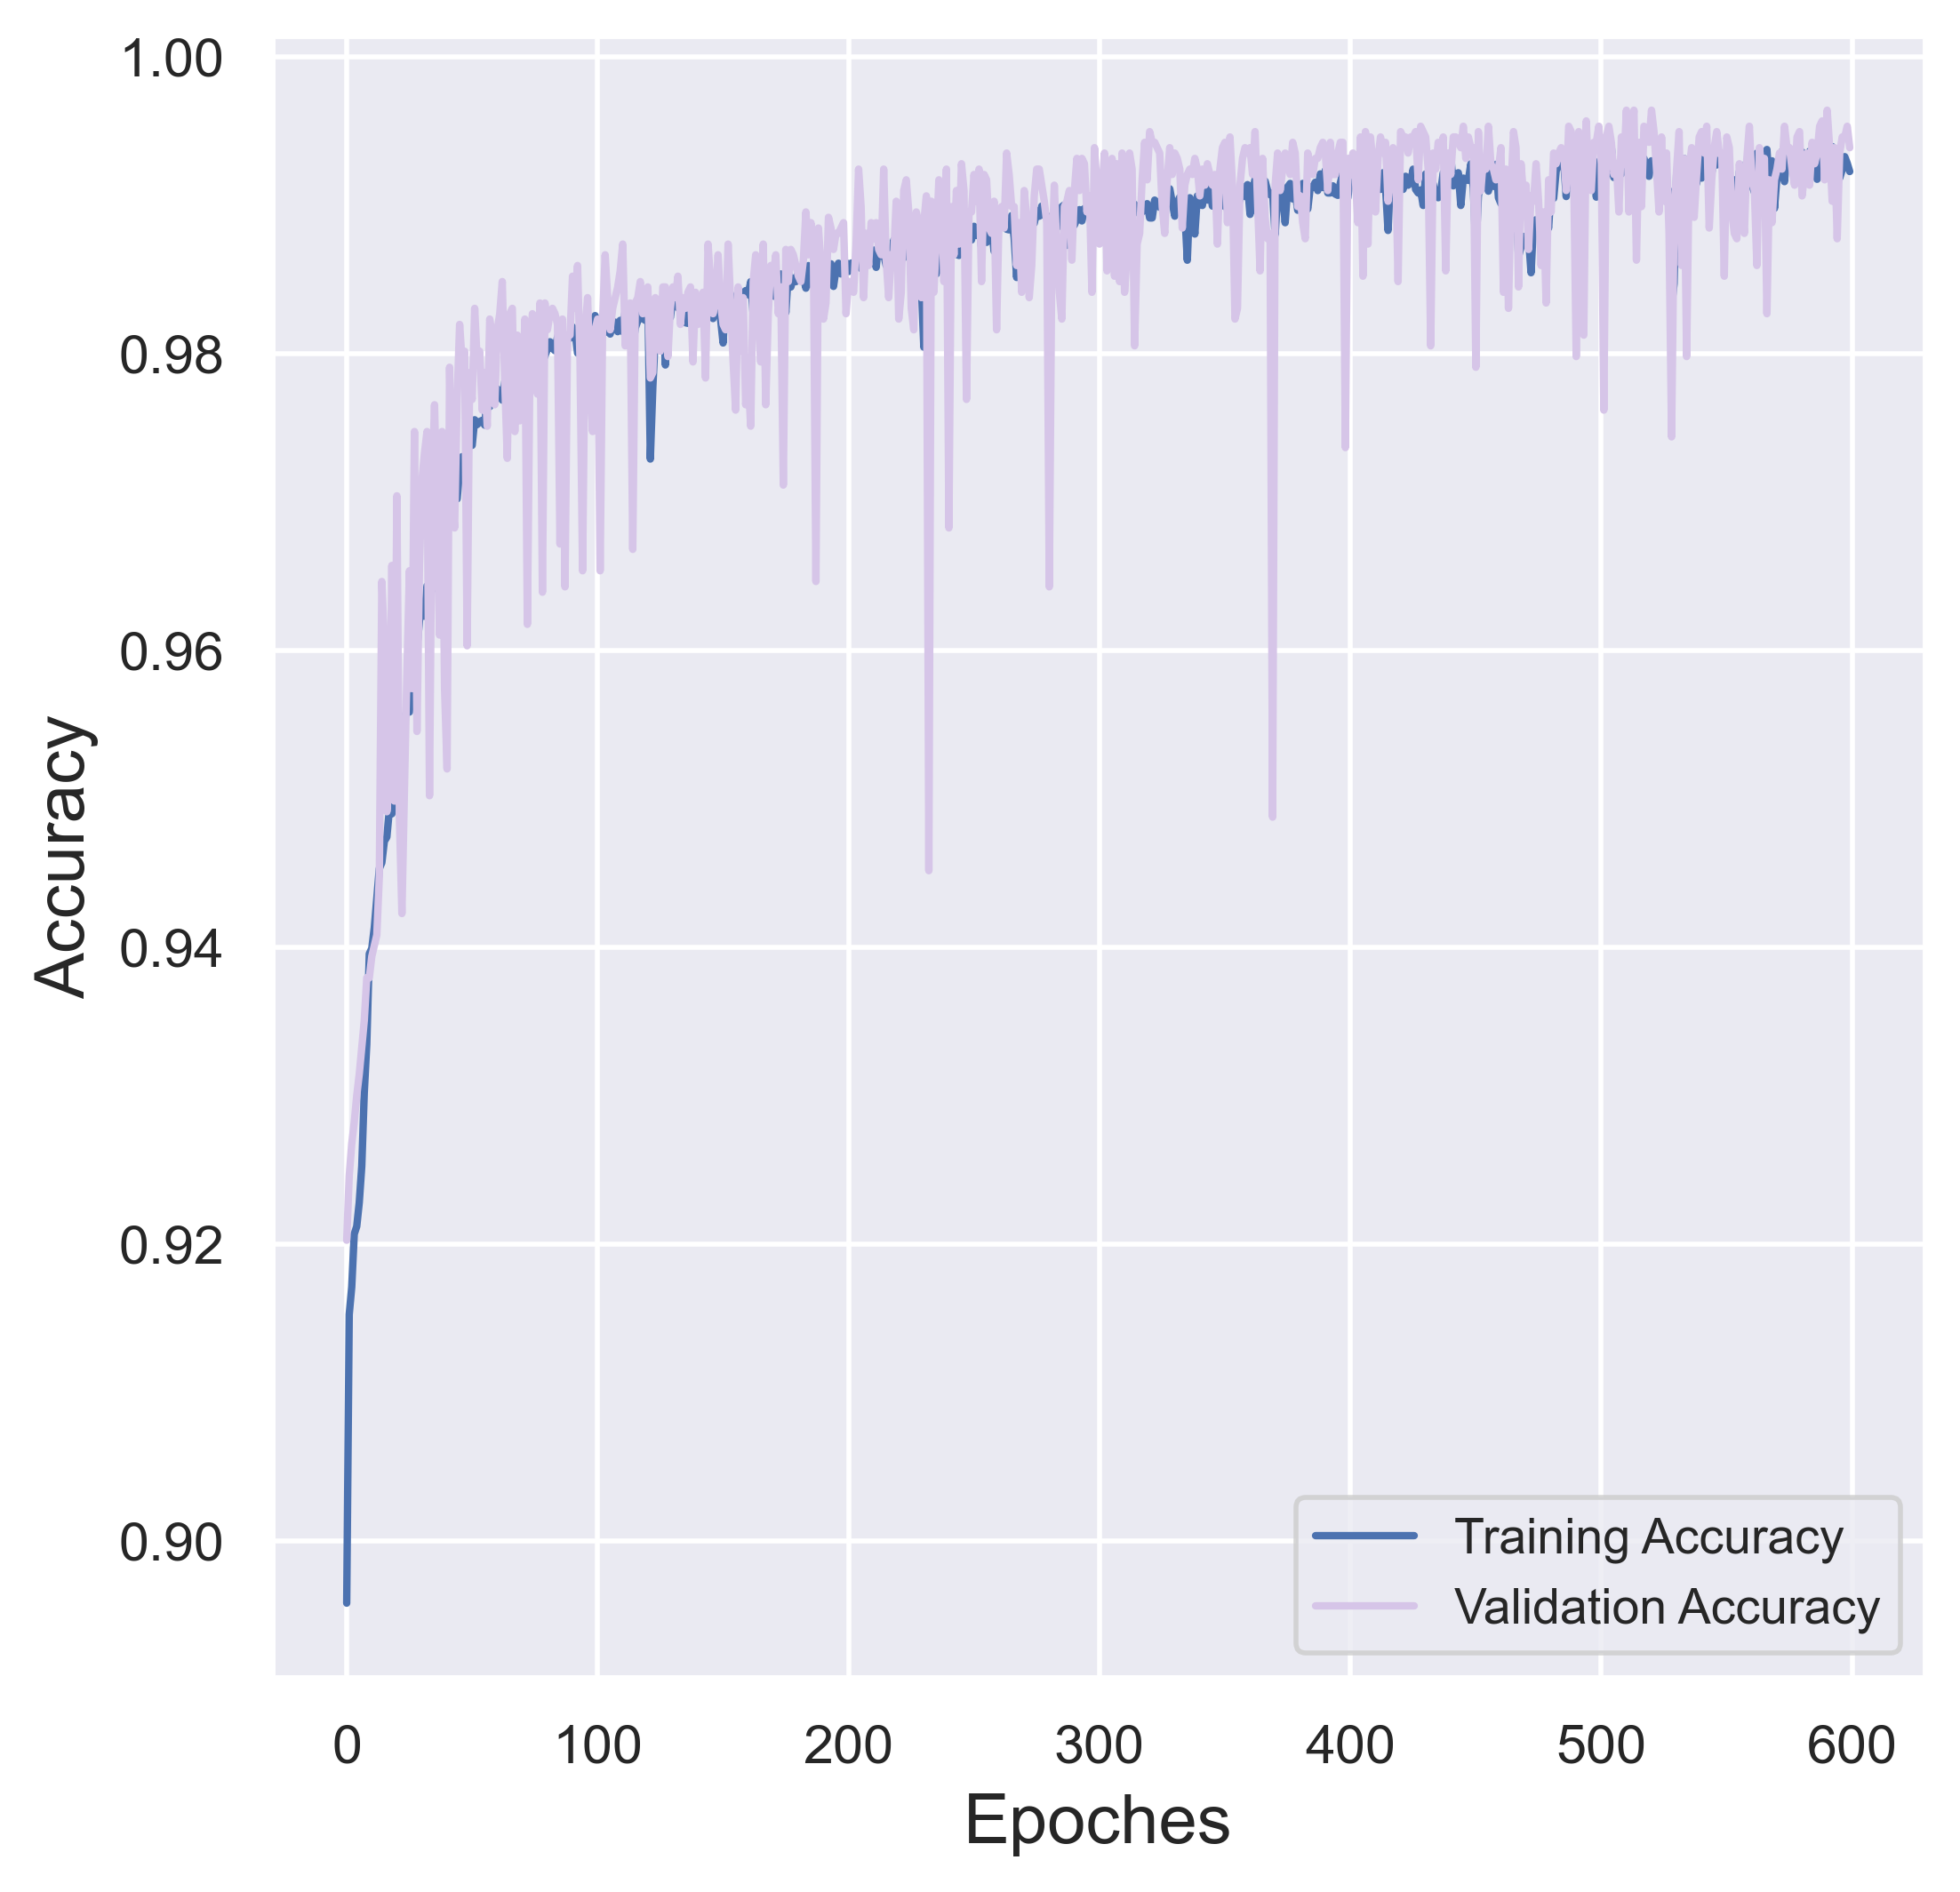

In [54]:
plt.figure(figsize=(6, 6), dpi=400)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy', color="#d6c5e8")
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoches', fontsize=14)
plt.legend(fontsize=10)
plt.savefig("accuracy1.png", dpi=400)
# plt.show()

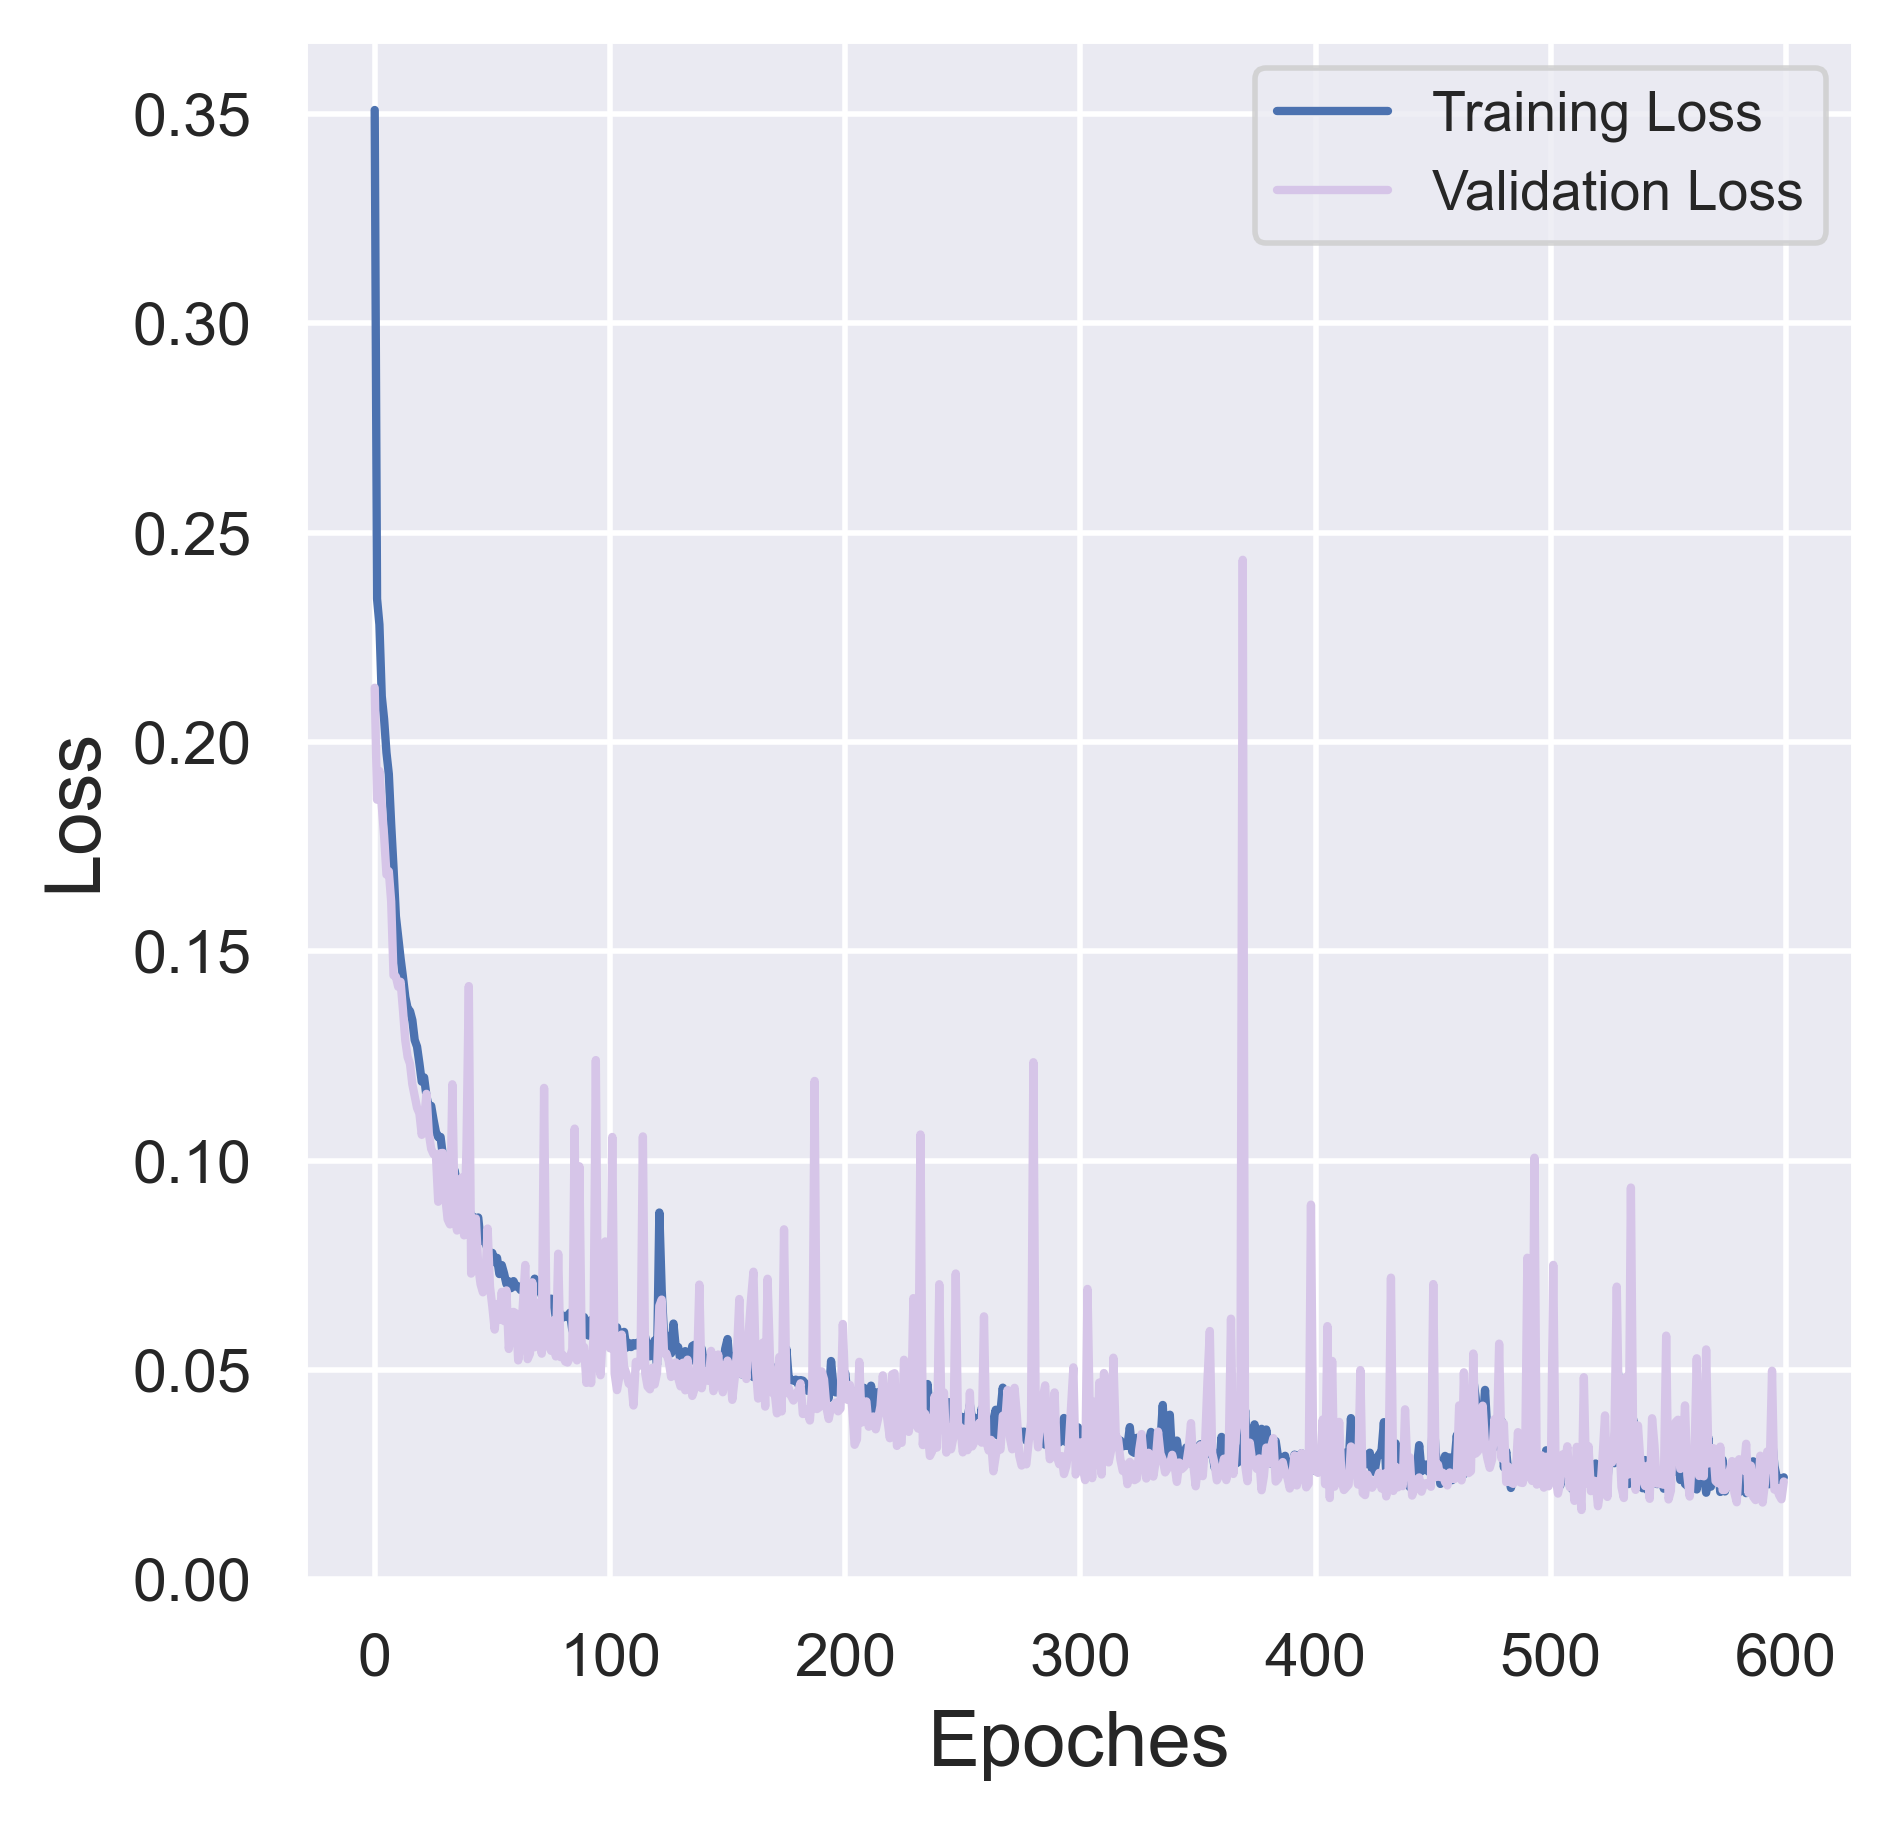

In [52]:
plt.figure(figsize=(5,5), dpi=400)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', color="#d6c5e8")
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoches',fontsize=14)
plt.legend(loc='upper right',fontsize=10, ncol=1, frameon=True)
plt.savefig("val_loss1", dpi=400)

In [31]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 0.022177107632160187
Test Accuracy: 0.993261456489563


In [32]:
print(X_test.shape)
print(X_test)

(11872, 25, 1)
[[[ 1.62313067]
  [ 1.52271383]
  [ 1.3949046 ]
  ...
  [-1.32553433]
  [-1.32553433]
  [-1.30726834]]

 [[ 1.36521918]
  [ 1.30977107]
  [ 1.24928063]
  ...
  [-1.47781396]
  [-1.62601292]
  [-1.76816632]]

 [[ 2.12239889]
  [ 1.87367029]
  [ 1.61995549]
  ...
  [-1.08129212]
  [-1.05145387]
  [-1.02409078]]

 ...

 [[ 1.40166081]
  [ 1.33390693]
  [ 1.25486254]
  ...
  [-1.49273691]
  [-1.67340452]
  [-1.85030391]]

 [[-1.72921767]
  [-1.57257843]
  [-1.41598437]
  ...
  [ 1.40352191]
  [ 1.56011597]
  [ 1.56011597]]

 [[-1.75830578]
  [-1.62138207]
  [-1.4502225 ]
  ...
  [ 1.32287259]
  [ 1.4597963 ]
  [ 1.56252364]]]


In [33]:
pre = model.predict(X_test).argmax(1)
print(classification_report(y_test,pre))

ValueError: as_list() is not defined on an unknown TensorShape.

In [34]:
# df_1 = pd.read_excel('out30abnormal_1007_1.xlsx')
# mmm = df_1.iloc[:, 0:26]
# mmm = mmm.values


In [35]:
#    # 可视化原结果与预测结果
# m=len(pre)
# x1 = np.array(range(0,26))
# x2 = [25]
# pl_xtest = X_test.reshape(m,25)
# pl_xtest = pd.DataFrame(pl_xtest)
# pl_ytest = y_test.reshape(m,1)
# pl_ytest = pd.DataFrame(pl_ytest)
# pl_ypre = pre.reshape(m,1)
# pl_ypre = pd.DataFrame(pl_ypre)
# pl_all = pd.concat([pl_xtest,pl_ytest,pl_ypre],axis = 1)   
# # # pl_real.columns = [np.array(range(0,26))]
# pl_all = pl_all.values
# pl_all
# f1 = plt.figure(figsize=(5,10), dpi=200)
# # plt.subplot(311)
# # plt.title('label 2',fontsize='medium')
# # cmap = plt.get_cmap('viridis')
# # colors = cmap(np.linspace(0,1,m))
# # for i,row in enumerate(pl_all):
# #     if row[25] == 2:
# #         plt.scatter(x1,row[0:26], c=colors[i])
# #         plt.scatter(x2,row[26],c=colors[i],marker = 'v')
# plt.subplot(312)
# plt.axis("on")
# plt.gca().set_axisbelow(True)
# plt.grid(axis="both",linestyle="-")
# plt.gca().set_facecolor("#F5F5F5")
# # ax.yaxis.grid(True)
# # ax.xaxis.grid(True)
# # plt.rcParams["axes.facecolor"] = "gray"
# plt.title('label 1',fontsize='medium')
# plt.xlabel("sampling point")
# # plt.axvline(x=0,color="black",linestyle="--")
# plt.ylabel("Ventilator Flow(L/min)")
# # plt.axhline(y=0,color="black",linestyle="--")
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 1:
#         plt.scatter(x1,row[0:26], c=colors[i])
# #         plt.scatter(x2,row[26],c=colors[i],marker = 'v')
# # plt.subplot(313)
# # plt.title('label 0',fontsize='medium')
# # cmap = plt.get_cmap('viridis')
# # colors = cmap(np.linspace(0,1,m))
# # for i,row in enumerate(pl_all):
# #     if row[25] == 0:
# #         plt.scatter(x1,row[0:26], c=colors[i])
# #         plt.scatter(x2,row[26],c=colors[i],marker = 'v')

In [36]:
# f1 = plt.figure(figsize=(5,10), dpi=200)
# plt.subplot(312)
# plt.axis("on")
# plt.gca().set_axisbelow(True)
# plt.grid(axis="both",linestyle="-")
# plt.gca().set_facecolor("#F5F5F5")
# # ax.yaxis.grid(True)
# # ax.xaxis.grid(True)
# # plt.rcParams["axes.facecolor"] = "gray"
# plt.title('label 2',fontsize='medium')
# plt.xlabel("sampling point")
# # plt.axvline(x=0,color="black",linestyle="--")
# plt.ylabel("Ventilator Flow(L/min)")
# # plt.axhline(y=0,color="black",linestyle="--")
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 2:
#         plt.scatter(x1,row[0:26], c=colors[i])

In [37]:
# f1 = plt.figure(figsize=(5,10), dpi=200)
# plt.subplot(313)
# plt.axis("on")
# plt.gca().set_axisbelow(True)
# plt.grid(axis="both",linestyle="-")
# plt.gca().set_facecolor("#F5F5F5")
# plt.title('label 0',fontsize='medium')
# plt.xlabel("sampling point")
# # plt.axvline(x=0,color="black",linestyle="--")
# plt.ylabel("Ventilator Flow(L/min)")
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 0:
#         plt.scatter(x1,row[0:26], c=colors[i])
# #         plt.scatter(x2,row[26],c=colors[i],marker = 'v')

In [38]:
# from mpl_toolkits import mplot3d
# z = np.array(range(0,m))
# f1 = plt.figure(figsize=(5,10), dpi=200)
# ax = plt.axes(projection='3d')
# plt.subplot(111)
# plt.title('label 2',fontsize='medium')
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 2:
#         ax.scatter3D(x1,row[0:26],z[i], c=colors[i])
#         ax.scatter3D(x2,row[26],z[i], c=colors[i],marker = '+')
# ax.set_xlabel("sampling point")
# # plt.axvline(x=0,color="black",linestyle="--")
# ax.set_ylabel("Ventilator Flow(L/min)")
# ax.set_zlabel('sampling number')

In [39]:
# from mpl_toolkits import mplot3d
# z = np.array(range(0,m))
# f1 = plt.figure(figsize=(5,10), dpi=200)
# ax = plt.axes(projection='3d')
# plt.subplot(111)
# plt.title('label 1',fontsize='medium')
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 1:
#         ax.scatter3D(x1,row[0:26],z[i], c=colors[i])
#         ax.scatter3D(x2,row[26],z[i], c=colors[i],marker = '+')

In [40]:
# from mpl_toolkits import mplot3d
# z = np.array(range(0,m))
# f1 = plt.figure(figsize=(5,10), dpi=200)
# ax = plt.axes(projection='3d')
# plt.subplot(111)
# plt.title('label 0',fontsize='medium')
# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0,1,m))
# for i,row in enumerate(pl_all):
#     if row[25] == 0:
#         ax.scatter3D(x1,row[0:26],z[i], c=colors[i])
#         ax.scatter3D(x2,row[26],z[i], c=colors[i],marker = '+')

In [41]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
import seaborn as sns
sns.set()

In [43]:
print(y_test.shape)
print(pre.shape)

(11872,)
(25,)


In [44]:

C2 = metrics.confusion_matrix(y_test, pre, labels=[0,1,2])

ValueError: Found input variables with inconsistent numbers of samples: [11872, 25]

In [ ]:
plt.figure()
classes = [0,1,2]
plt.imshow(C2, interpolation='nearest', cmap=plt.cm.Oranges)  # 按照像素显示出矩阵
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
 
thresh = C2.max() / 2.
# iters = [[i,j] for i in range(len(classes)) for j in range((classes))]
# ij配对，遍历矩阵迭代器
iters = np.reshape([[[i, j] for j in range(len(classes))] for i in range(len(classes))], (C2.size, 2))
for i, j in iters:
    plt.text(j, i, format(C2[i, j]))  # 显示对应的数字
 
plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# 误触发率计算
sum = 0
for i in range(len(classes)):
    for j in range(len(classes)):
        sum += C2[i,j]
sum_false = 0
for i in range(len(classes)):
    for j in range(len(classes)):
        if i != j:
            sum_false += C2[i,j]
falsetriggerrate = sum_false/sum     # 误触发率
falsetriggerrate

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
C2=np.array([[3057,15,16],[35,1142,9],[37,8,1144]])
plt.figure()
classes = [0,1,2]
plt.imshow(C2, interpolation='nearest', cmap=plt.cm.viridis)  # 按照像素显示出矩阵
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, ["Non-I/E","Expiratory","Inspiratory"])
plt.yticks(tick_marks, ["Non-I/E","Expiratory","Inspiratory"], rotation=90)
 
thresh = C2.max() / 2.
# iters = [[i,j] for i in range(len(classes)) for j in range((classes))]
# ij配对，遍历矩阵迭代器
iters = np.reshape([[[i, j] for j in range(len(classes))] for i in range(len(classes))], (C2.size, 2))
# for i in range(2):
#     for j in range(2):
#         plt.text(j, i, confusion_matrix[i,j], ha='center', va='center', color='white')
for i, j in iters:
    if i == j:
        plt.text(j, i, format(C2[i, j]),ha='center', va='center', color='white')  # 显示对应的数字
    else:
        plt.text(j, i, format(C2[i, j]),ha='center', va='center', color='black')  # 显示对应的数字
plt.grid(False)
plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.savefig("confusion_matrix.png",dpi=300)

In [ ]:
np.arange(8.6342,)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 创建混淆矩阵
confusion_matrix = np.array([[10, 5], [3, 8]])

# 绘制混淆矩阵
plt.imshow(confusion_matrix, cmap='Blues')

# 设置坐标轴标签
plt.xticks([0, 1], ['Predicted 0', 'Predicted 1'])
plt.yticks([0, 1], ['True 0', 'True 1'])

# 添加数值标签
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i,j], ha='center', va='center', color='white')

# 不显示网格
plt.grid(False)

# 显示图像
plt.show()